# 2019 2nd ML month with KaKR
https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

평가방법 : RMSE

사용 모델 : xgboost, lightgbm 

데이터 경로 : /home/ssac16/aiffel/kaggle_kakr_housing/data


In [96]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#data load 
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [97]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


train데이터에서 date를 알아보기 쉽게 바꾸어준다. 
이때 값을 int형으로 유지해야 데이터로써 사용 가능하다. 
그리고 이 데이터는 시계열 데이터가 아니기 때문에 id값은 필요가 없으므로 삭제한다. 
price는 훈련시에 정답이 되는 데이터 이므로 분리해서 따로 저장한다. 

test에서도 마찬가지로 id를 삭제하고 date를 알아보기 쉽게 바꾸어 준다. 
test에서는 price가 존재하지 않기 때문에 처리하지 않아도 된다. 


### train 데이터 수정 

In [98]:
#date 수정 
train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
#price 따로 저장 (y)
y = train['price']
del train['price']
#id 삭제 
del train['id']

print(train.columns)
train.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


### test 데이터 수정 

In [99]:
#date 수정 
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
#id 삭제
del test['id']

print(test.columns)
test.head()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


### train, test데이터 값 정규화 

In [100]:
train_len = len(train)
data = pd.concat((train, test), axis=0)
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


### price 값 (y) 정규화

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


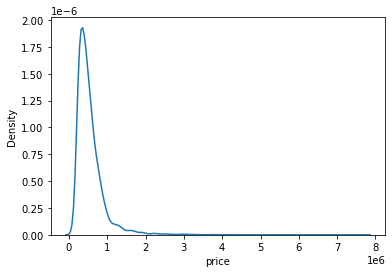

In [101]:
print(y)
sns.kdeplot(y)
plt.show()

위에서 확인 할 수 있듯이 y값은 매우 큰 값들로 이루어져 있고 한쪽으로 치우친 형태를 하고 있다. 이를 정규화 해준다.

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64


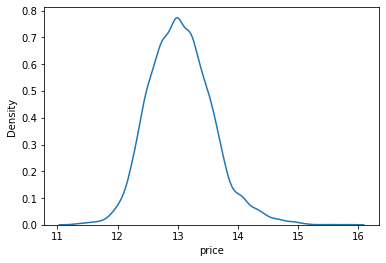

In [102]:
y = np.log1p(y)
print(y)
sns.kdeplot(y)
plt.show()

### 데이터 학습전 전체 데이터 확인 - info() 이용 

In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  float64
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  float64
 4   sqft_lot       15035 non-null  float64
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  float64
 11  sqft_basement  15035 non-null  float64
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

모든 열에 존재하는 데이터에 대하여 정수또는 실수로 이루어져 있음을 확인할 수 있다. 정상적으로 데이터의 전처리가 이루어 졌으니 모델을 학습시킨다. 

### RMSE함수 구현 

In [104]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


### 모델 생성

In [105]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor


# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


### 훈련된 모델에 대하여 RMSE를 return 하는 함수 구현 

In [106]:
def get_scores(models, train, y):
    df={}
    for model in models:
      # 모델 이름 획득
      model_name = model.__class__.__name__

      # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
      X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

      # 모델 학습
      model.fit(X_train, y_train)

      # 예측
      y_pred = model.predict(X_test)

      # 예측 결과의 rmse값 저장
      df[model_name] = rmse(y_test, y_pred)

      # data frame에 저장
      score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    print(score_df)
get_scores(models, train, y)


                                    RMSE
GradientBoostingRegressor  128360.173766
RandomForestRegressor      125380.784576
LGBMRegressor              111906.947718
XGBRegressor               110319.301793


### 하이퍼 파라미터 튜닝 

#### GridSearchCV 

    param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
    scoring : 모델의 성능을 평가할 지표
    cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
    verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
    n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수


In [108]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    
    #RMSE값 계산 후 정렬 
    results['RMSE']=np.expm1(results['RMSLE'])
    results = results.sort_values('RMSE')

    return results

#### 1. Lightgbm 하이퍼파라미터 측정

In [83]:
param_grid = {
    'n_estimators': [50, 60, 70, 80, 90, 100],
    'max_depth': [1,2,3,4,5,6,7,8,9, 10],
    'learning_rate':[0.1,0.2,0.3,0.4,0.5,0.6],
    'num_leaves':[255,511,1023]
}
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  32 tasks      | elapsed:    1.1s
[Parallel(n_jobs=5)]: Done 498 tasks      | elapsed:   10.9s
[Parallel(n_jobs=5)]: Done 875 tasks      | elapsed:   32.3s
[Parallel(n_jobs=5)]: Done 1693 tasks      | elapsed:   58.1s
[Parallel(n_jobs=5)]: Done 2653 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 3922 tasks      | elapsed:  2.1min
[Parallel(n_jobs=5)]: Done 5400 out of 5400 | elapsed:  2.9min finished


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE,RMSE
143,0.1,8,100,1023,-0.027335,0.165333,0.179786
142,0.1,8,100,511,-0.027335,0.165333,0.179786
141,0.1,8,100,255,-0.027335,0.165333,0.179786
160,0.1,9,100,511,-0.027403,0.165539,0.180029
159,0.1,9,100,255,-0.027403,0.165539,0.180029
...,...,...,...,...,...,...,...
4,0.1,1,60,511,-0.067751,0.260290,0.297306
3,0.1,1,60,255,-0.067751,0.260290,0.297306
2,0.1,1,50,1023,-0.073398,0.270920,0.311170
1,0.1,1,50,511,-0.073398,0.270920,0.311170


가장 높은 성능을 발휘하는 hyperparameter를 이용하여 모델을 만든다. 

In [109]:
# train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

#모델 생성
model = LGBMRegressor(max_depth=8, num_iterations=500, n_estimators=100, learning_rate=0.1, num_leaves=1023,random_state=random_state)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

#RMSE값 생성 
df={}
# 예측 결과의 rmse값 저장
df['Lightgbm'] = rmse(y_test, y_pred)

# data frame에 저장
score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
print(score_df)


prediction = model.predict(test)
prediction









/home/ssac16/anaconda3/envs/aiffel/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


                   RMSE
Lightgbm  110917.322056


array([13.18513705, 13.19505872, 14.04466544, ..., 13.05942247,
       12.7140899 , 12.9442236 ])

### CSV파일로 저장 

In [110]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [111]:
save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

/home/ssac16/anaconda3/envs/aiffel/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


/home/ssac16/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.0168.csv saved!


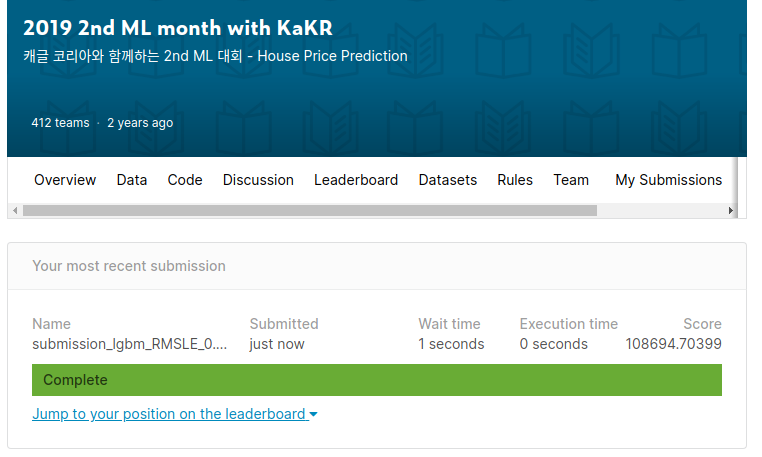

In [112]:
from IPython.display import Image 
Image("/home/ssac16/Pictures/Screenshot from 2021-02-16 20-40-14.png")